# PBVS & IBVS ROS Integration
**Authors**:
<span style="color: red;">Javier González Barreda</span> &
<span style="color: red;">Vicent Santamarta Martinez</span>
<br/><br/>
**ROS Version:** ROS 2 Humble

## PBVS Development

For this exercise we had to integrate our implementation of the Position Based Visual Servoing (PBVS) with the ROS communication.<br/>
Our implementation consists of three Nodes:
- [Feature Extractor](ros2_ws/src/pbvs/pbvs/feature_extractor.py)
- [Controller](ros2_ws/src/pbvs/pbvs/controller.py)
- [Actuator](ros2_ws/src/pbvs/pbvs/actuator.py)

The behavior of all three nodes is based on the modules developed fot the [Task 2.3 PBVS](Tasks_23_24/VSM_PBVS.py)


We also implemented the **launcher**, which can be found in the [pbvs.launch.py ](ros2_ws/src/pbvs/launch/pbvs.launch.py) file, so we could run all three Nodes in one terminal.


### Communication
This figure aims to present how the communication between the nodes has been implemented. 
<br/><br/>
<img src="imgs/pbvs_ROS.jpg" width="50%" height="50%">

### [Feature Extractor](ros2_ws/src/pbvs/pbvs/feature_extractor.py)
First we have the **_Feature Extractor_** which from the camera informartion computes the current camera pose to extract the _feature data_ and publishes the data in the 'feature_data' task.
``` python
    # Feature data task to pubish
    self.publisher_ = self.create_publisher(Float64MultiArray, 'feature_data', 10)
    # Comupute feature data from the camera data
    def compute_pose(self):
        # Compute pose
        self.uv = self.camera.project_point(self.P, objpose=self.pose_g)
        # Store uv history
        self.uv_history.append(self.uv)
        np.save('/home/sjk015/Documents/SKJ015-Intelligent_Control/Task_4_1/outputs/PBVS/uv_history.npy', self.uv_history)
        # Estimate the camera pose
        Te_C_G = self.camera.estpose(self.P, self.uv, frame="camera") 
        # convert to numpy array, flatten and then to a list
        Te_C_G = Te_C_G.A.flatten().tolist()
        # Compose message
        msg = Float64MultiArray()
        msg.data = Te_C_G
        self.publisher_.publish(msg)
        #self.get_logger().info('Publishing: "%s"' % msg.data)
```

This node is also the one that starts the cicle of messages which is why in the code you will find the following snippet of code, which makes the node wait some time to make sure all of the Nodes are listening, and then start the loop

``` python
    # Wait for the rest of the nodes to listen
    start_time = time.time()
    while time.time() - start_time < 1:
        pass
    
    # First call
    self.compute_pose()
```

### [Controller](ros2_ws/src/pbvs/pbvs/controller.py)

After the _feature extractor_ we have the **_Controller_** which receives the feature data from the '_feature_data_' task and computes de error Delta to then publish it in the '_Delta_' task.

```python
    # Prepare subscriber
    self.subscription = self.create_subscription(
        Float64MultiArray,
        'feature_data',
        self.compute_delta,
        10
    )
    # Publisher for the Delta task
    self.publisher_ = self.create_publisher(Float64MultiArray, 'delta', 10)

    def compute_delta(self, msg):
        # Reshape data to 4x4 matrix
        data = np.array(msg.data).reshape(4,4)
        #self.get_logger().info('Received: "%s"' % data)
        
        # Compute the new delta
        Te_C_G = SE3(data)
        T_delta = Te_C_G * self.pose_d.inv()   
        # Store tdelta history
        self.vel_history.append(T_delta.A)
        np.save('/home/sjk015/Documents/SKJ015-Intelligent_Control/Task_4_1/outputs/PBVS/vel_history.npy', self.vel_history)             
        T_delta = T_delta.A.flatten().tolist()
        #self.get_logger().info('Final pos: \n %s' %self.pose_d.A)
        
        # Check if the error is less than the threshold
        self.get_logger().info('Norm: %s' % np.linalg.norm(T_delta))
        if(np.linalg.norm(T_delta) < self.eterm):
            stop_msg = Bool() 
            self.publisher_stop.publish(stop_msg)
            self.get_logger().info('Stopping the controller...')
            # Finish the program
            sys.exit()
            
        # Compose message
        msg = Float64MultiArray()
        msg.data = T_delta
        #self.get_logger().info('Publishing: "%s"' % msg.data)
        self.publisher_.publish(msg)
```

The controller is also the Node that finishes the program when camera arrives to the position that is why we can find this snnipet of code in the ``compute_delta()`` function
```python
    if(np.linalg.norm(T_delta) < self.eterm):
        stop_msg = Bool() 
        self.publisher_stop.publish(stop_msg)
        self.get_logger().info('Stopping the controller...')
        # Finish the program
        sys.exit()
```

### [Actuator](ros2_ws/src/pbvs/pbvs/actuator.py)


Finally we have the **Actuator** which from the Delta, will move the camera to the next position and then publish the new pose.
```python
    # Prepare publisher
    self.publisher_ = self.create_publisher(Float64MultiArray, 'camera_pose', 10)
    
    # Prepare subscriber
    self.subscription = self.create_subscription(
        Float64MultiArray,
        'delta',
        self.apply_velocity,
        10
    )

    def apply_velocity(self, msg):
    # Reshape data to 4x4 matrix
    data = np.array(msg.data).reshape(4,4)
    
    # Compute the new delta
    T_delta = SE3(data)
    Td = T_delta.interp1(self.lmbda)
    self.camera.pose @= Td
    # Store new camera pose
    self.c_pose_history.append(self.camera.pose.A)
    # Save history to file
    np.save('/home/sjk015/Documents/SKJ015-Intelligent_Control/Task_4_1/outputs/PBVS/c_pose_history.npy', self.c_pose_history)
    #self.get_logger().info('New camera pose: \n "%s"' % self.camera.pose.A)
    
    # Send new pose
    msg = Float64MultiArray()
    msg.data = self.camera.pose.A.flatten().tolist()
    
    self.publisher_.publish(msg)
```
Becase we cannot reference properties from one node to another, we need to publish the new camera pose so the **Feature Extractor** can update its own camera data, that is why you will find a subscription on the node. 
```python
    # Prepare subscriber
    self.subscription = self.create_subscription(
        Float64MultiArray,
        'camera_pose',
        self.update_camera_pose,
        10
    )
```

## PBVS + ROS Visualization

### Storing the Nodes History

All three nodes store their data (camera pose, velocity and uv) in a history array, then we store it in npy file so we can load them here in the notebook and a make a visualization to make sure that the execution is correct. It was easier to debug the results this way since seeing everything in one terminal because of the launcher, made it too complicated. The following code is for visualizing the stored data

In [1]:
from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

#### Setup PBVS from task 2.3

In [3]:
from Tasks_23_24 import VSM_PBVS as PBVS

In [5]:
# Setup camera with the same parameters
camera = CentralCamera.Default(pose = SE3.Trans(1, 1, -2));
# 4-points goal
P = mkgrid(2, 0.5)
#image-plane projections of the world points
p = camera.project_point(P, objpose=SE3.Tz(1))
T_Cd_G = SE3.Tz(1);

pbvs = PBVS(camera, P=P, pose_g=SE3.Trans(-1, -1, 2), pose_d=T_Cd_G, plotvol=[-1, 2, -1, 2, -3, 2.5]);

TypeError: 'module' object is not callable

In [8]:
pbvs.run(200)

NameError: name 'pbvs' is not defined

#### Visualizations

In [ ]:
# Load histories
uv = np.load('outputs/PBVS/uv_history.npy')
c_pose = np.load('outputs/PBVS/c_pose_history.npy')
vel = np.load('outputs/PBVS/vel_history.npy')

In [ ]:
# Check array shapes
print('uv shape:', uv.shape)
print('c_pose shape:', c_pose.shape)
print('vel shape:', vel.shape)

uv shape: (83, 2, 4)
c_pose shape: (82, 4, 4)
vel shape: (83, 4, 4)


In [ ]:
def plot_feature_trajectory(uv_history, camera_pose_history, T_delta_history, camera_width, camera_height):
    """
    Plot feature trajectory from simulation

    Show image feature points versus time.
    """

    if len(uv_history) == 0 or len(camera_pose_history) == 0 or len(T_delta_history) == 0:
        return

    # Extract the number of feature points
    npoints = uv_history.shape[2]

    # Plot the trajectory for each feature point
    for i in range(npoints):
        u = uv_history[:, 0, i]  # get u data for i'th point
        v = uv_history[:, 1, i]  # get v data for i'th point
        plt.plot(u, v, "b")

    # Extract the x and y coordinates
    x_coords_initial = uv_history[0, 0, :]
    y_coords_initial = uv_history[0, 1, :]

    # Include the first point at the end to close the loop
    x_coords_initial = np.append(x_coords_initial, x_coords_initial[0])
    y_coords_initial = np.append(y_coords_initial, y_coords_initial[0])
    # Mark the initial position of the feature points
    plt.plot(x_coords_initial, y_coords_initial, "o--", markeredgecolor="k", markerfacecolor="w", label="initial")


    # Extract the x and y coordinates
    x_coords_final = uv_history[-1, 0, :]
    y_coords_final = uv_history[-1, 1, :]

    # Include the first point at the end to close the loop
    x_coords_final = np.append(x_coords_final, x_coords_final[0])
    y_coords_final = np.append(y_coords_final, y_coords_final[0])
    # Mark the final position of the feature points
    plt.plot(x_coords_final, y_coords_final, "k*:", markeredgecolor="k", markerfacecolor="k", label="final")

    plt.grid(True)
    plt.xlabel("u (pixels)")
    plt.ylabel("v (pixels)")
    plt.xlim(0, camera_width)
    plt.ylim(0, camera_height)
    plt.legend()
    ax = plt.gca()
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.set_facecolor("lightyellow")
    plt.show()

# Assuming uv_history, camera_pose_history, and T_delta_history are given with appropriate shapes
camera_width = 640 
camera_height = 480


##### Trajectory

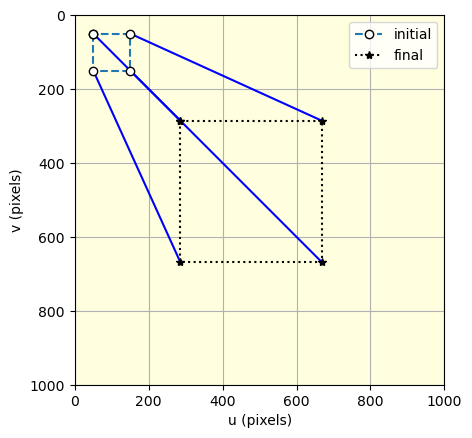

In [ ]:
# PBVS + ROS
plot_feature_trajectory(uv, c_pose, vel, 1000, 1000)

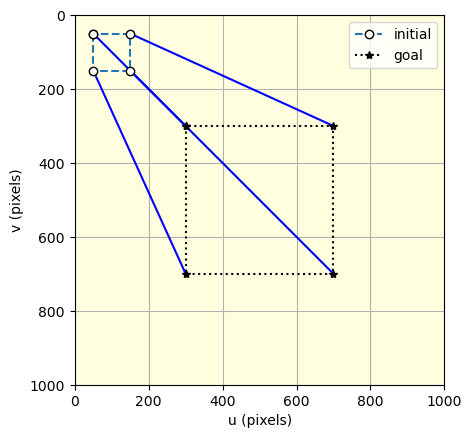

In [ ]:
# PBVS Task 2.3
pbvs.plot_p()

##### Velocity

In [ ]:
def plot_vel(history_vel):
    """
    Plot camera velocity from simulation

    Show camera velocity versus time.
    """
    if len(history_vel) == 0:
        return

    # Convert history to numpy array
    vel = np.array(history_vel)  # Shape (83, 4, 4)

    # Extract translational velocities (v_x, v_y, v_z)
    translational_vel = vel[:, :3, 3]  # Shape (83, 3)

    # Extract rotational velocities (omega_x, omega_y, omega_z)
    rotational_vel = vel[:, :3, :3]  # Shape (83, 3, 3)

    # For simplicity, we might want to plot the rotational velocities as norms
    rotational_norms = np.linalg.norm(rotational_vel, axis=(1, 2))  # Shape (83,)

    # Plot translational velocities
    plt.figure(figsize=(10, 5))
    plt.plot(translational_vel[:, 0], "-", label="$v_x$")
    plt.plot(translational_vel[:, 1], "-", label="$v_y$")
    plt.plot(translational_vel[:, 2], "-", label="$v_z$")

    # Plot rotational velocities
    plt.plot(rotational_norms, "--", label=r"$\omega$")

    plt.ylabel("Cartesian velocity")
    plt.xlabel("Time step")
    plt.xlim(0, len(history_vel) - 1)
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.title("Camera Velocity vs Time")
    plt.show()

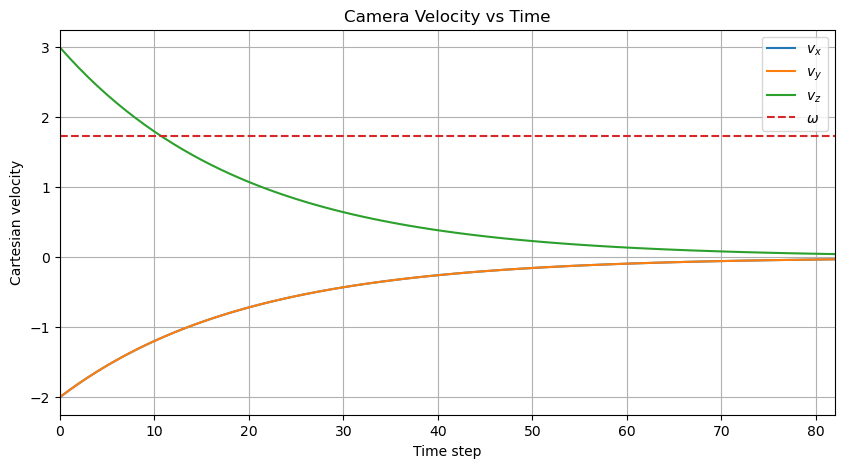

In [ ]:
# PBVS + ROS
plot_vel(vel)

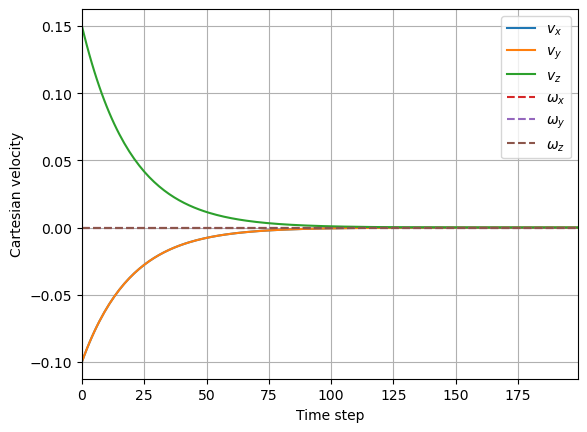

In [ ]:
# PBVS Task 2.3
pbvs.plot_vel()

##### Pose

In [ ]:
def plot_pose(c_pose_history):
    """
    Plot camera trajectory from simulation

    Show camera pose versus time, as two plots: translation and rotation
    in RPY angles.

    :seealso: :meth:`plot_p` :meth:`self.plot_vel` :meth:`plot_jcond` :meth:`plot_z` :meth:`plot_error`
    """

    if len(c_pose_history) == 0:
        return

    # Extract translations (x, y, z) and rotations (RPY) from the c_pose history
    translations = np.array([pose[:3, 3] for pose in c_pose_history])
    rotations = np.array([R.from_matrix(pose[:3, :3]).as_euler('xyz', degrees=False) for pose in c_pose_history])

    plt.figure(figsize=(12, 6))

    # Cartesian camera position vs timestep
    plt.subplot(211)
    plt.plot(translations)
    plt.xlim(0, len(c_pose_history) - 1)
    plt.ylabel("Camera position (m)")
    plt.legend(["x", "y", "z"])
    plt.grid(True)

    # Camera orientation (RPY) vs timestep
    plt.subplot(212)
    plt.plot(rotations)
    plt.ylabel("Camera orientation (rad)")
    plt.xlabel("Time step")
    plt.xlim(0, len(c_pose_history) - 1)
    plt.legend([r"$\alpha$", r"$\beta$", r"$\gamma$"])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

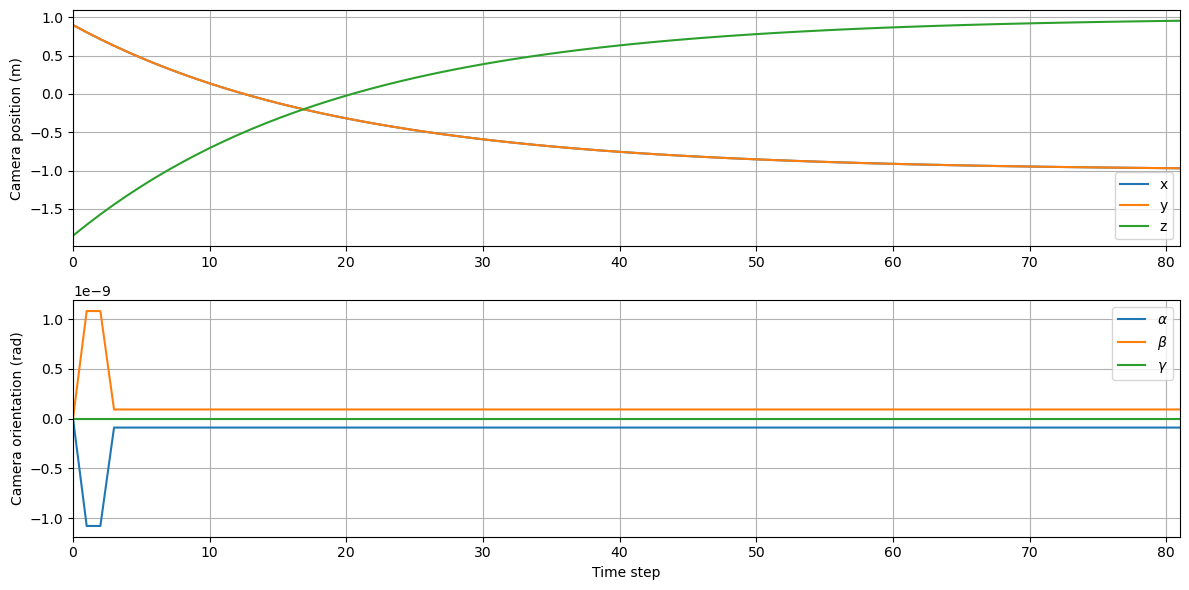

In [ ]:
# PBVS + ROS
plot_pose(c_pose)

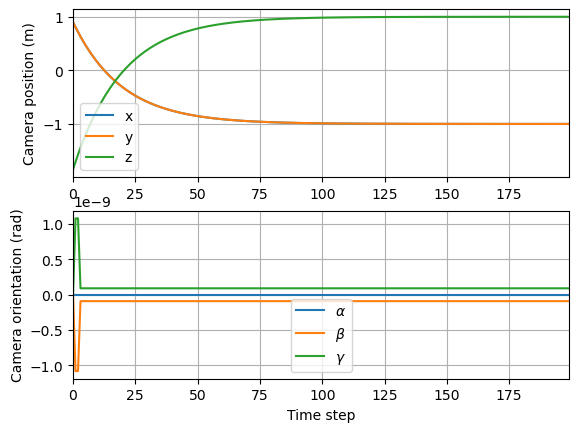

In [ ]:
# PBVS Task 2.3
pbvs.plot_pose()

## IBVS Development

For this part of the exercise we have implemented the integration of the Image Based Visual Servoing (IBVS) model with ROS. As with the PBVS our implementation consists of three Nodes:
- [Feature Extractor](ros2_ws/src/ibvs/ibvs/feature_extractor.py)
- [Controller](ros2_ws/src/ibvs/ibvs/controller.py)
- [Actuator](ros2_ws/src/ibvs/ibvs/actuator.py)

All three Nodes are based on the implementation made for the [Task 2.4](Tasks_23_24/VSM_IBVS.py)

We also implemented the **launcher**, which can be found in the [ibvs.launch.py ](ros2_ws/src/ibvs/launch/ibvs.launch.py) file, so we could run all three Nodes in one terminal.

### Communication
This figure aims to present how the communication between the nodes has been implemented. 
<br/><br/>
<img src="imgs/ibvs_ROS.jpg" width="50%" height="50%">

The tasks are very similar to the PBVS implimentation with the difference that for the IBVS the **Controller** needs to also update the pose of their internal camera data.

### [Feature Extractor](ros2_ws/src/ibvs/ibvs/feature_extractor.py)

The first node we have is the **_Feature Extractor_** which extracts the features data from the camera data nad publishes the results in the 'feature_data' task
```python
    def compute_pose(self):
        # Compute pose
        uv = self.camera.project_point(self.P)
        # Store uv in file
        self.uv_history.append(uv)
        np.save('/home/sjk015/Documents/SKJ015-Intelligent_Control/Task_4_1/outputs/IBVS/uv.npy', np.array(self.uv_history))
        # Compose message
        msg = Float64MultiArray()
        msg.data = uv.flatten().tolist()
        # Publish message
        self.publisher_.publish(msg)
        #self.get_logger().info('Publishing uv: "%s"' % msg.data)
```

As with the PBVS the feature extractor is the one to start the loop of communication, so it has a small section of code for waiting for the other Nodes to be listening before starting to send messages

```python
        # Wait for the rest of the nodes to start listening
        start_time = time.time()
        while time.time() - start_time < 1:
            pass
        
        # First call
        self.compute_pose()
```

### [Controller](ros2_ws/src/ibvs/ibvs/controller.py)

The next node in the line is the **_Controller_** which from the _feature data_ sent by the **_Feature Extractor_** computes the velocity at which the camera has to move
```python
    def compute_verlocity(self, msg):
        # Reshape uv data to 2x2 matrix
        uv = np.array(msg.data).reshape(2, 4)
        #self.get_logger().info('Received uv: "%s"' % uv)
        # Compute velocity
        self.e = uv - self.p_star
        self.e = self.e.flatten('F')
        self.J = self.camera.visjac_p(uv, self.depth)
        
        try:
            v = -self.lmbda * np.linalg.pinv(self.J) @ self.e
        except np.linalg.LinAlgError:
            sys.exit()
        
        # Store v in file
        self.v_history.append(v)
        np.save('/home/sjk015/Documents/SKJ015-Intelligent_Control/Task_4_1/outputs/IBVS/v.npy', self.v_history)
        # Check if we are in position
        if(np.linalg.norm(v) < self.eterm):
            sys.exit()
        
        if(np.linalg.norm(v) > 0.5):
            v = smbase.unitvec(v) * 0.5
        
        # Compose message
        msg = Float64MultiArray()
        msg.data = v.flatten().tolist()
        # Publish message
        self.publisher_.publish(msg)
        #self.get_logger().info('Publishing v: "%s"' % msg.data)
```

The **_Cotroller_** is also the node in charge to check wheter or not the servo has arrived to the desired position and if so, stop the program.

### [Actuator](ros2_ws/src/ibvs/ibvs/actuator.py)

As in the PBVS the **_Actuator_** receives the velocity data from the **_Controller_** and updates the camera position. All of the nodes subscribed to the _camera_pos_ task will also update their internal cameras.

``` python
    def apply_velocity(self, msg):
        # Reshape data to 1x6 matrix
        data = np.array(msg.data).reshape(1, 6)
        
        self.Td = SE3.Delta(data)
        self.camera.pose @= self.Td
        
        # Store new camera pose
        self.c_pose_history.append(self.camera.pose.A)
        # Save history to file
        np.save('/home/sjk015/Documents/SKJ015-Intelligent_Control/Task_4_1/outputs/IBVS/c_pose_history.npy', self.c_pose_history)
        
        # Send new pose
        msg = Float64MultiArray()
        msg.data = self.camera.pose.A.flatten().tolist()
        self.publisher_.publish(msg)
````

## IBVS + ROS Visualizations

As for the PBVS visualization, It was too difficult to understand what was happening by only looking at the logs in the terminal, so we've decided to store the computations of each node in a history file to be able to plot it here and see the results.

#### Set up IBVS from task 2.4

In [6]:
from Tasks_23_24 import VSM_IBVS as IBVS
# Goal
P = mkgrid(2, side=0.5, pose=SE3.Tz(2));

# desired pose
camera = CentralCamera.Default(pose=SE3.Trans(1, 1, -2));
pd = 200 * np.array([[-1, -1, 1, 1], [-1, 1, 1, -1]]) + np.c_[camera.pp]

# Defining the camera with default intrinsic parameters.
camera = CentralCamera.Default(pose=SE3.Trans(1, 1, -3) * SE3.Rz(0.6));

ibvs = IBVS(camera, P=P, p_d=pd)

TypeError: 'module' object is not callable

In [39]:
# Load IBVS history files
uv = np.load('IBVS/uv.npy')
c_pose = np.load('IBVS/c_pose_history.npy')
vel = np.load('IBVS/v.npy')

In [40]:
# Print shapes
print('uv shape:', uv.shape)
print('c_pose shape:', c_pose.shape)
print('vel shape:', vel.shape)

uv shape: (107, 2, 4)
c_pose shape: (106, 4, 4)
vel shape: (107, 6)


In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_trajectory(uv, c_pose, vel):
    """
    Plot feature trajectory from simulation

    Show image feature points versus time.

    :param uv: A numpy array of shape (107, 2, 4) representing the history of uv points.
    :param c_pose: A numpy array of shape (106, 4, 4) representing the history of camera poses.
    :param vel: A numpy array of shape (107, 6) representing the history of camera velocities.
    """
    n_points = uv.shape[2]
    n_timesteps = uv.shape[0]
    
    # Plot the trajectory of each feature point
    for i in range(n_points):
        u = uv[:, 0, i]
        v = uv[:, 1, i]
        plt.plot(u, v, "b", label="Trajectory" if i == 0 else "")
    
    # Mark the initial target shape
    initial_uv = uv[0]
    plt.plot(initial_uv[0, :], initial_uv[1, :], 'o--', markeredgecolor="k", markerfacecolor="w", label="Initial")

    # Mark the goal target shape (last uv position)
    final_uv = uv[-1]
    plt.plot(final_uv[0, :], final_uv[1, :], 'k*:', markeredgecolor="k", markerfacecolor="k", label="Goal")

    plt.grid(True)
    plt.xlabel("u (pixels)")
    plt.ylabel("v (pixels)")
    plt.xlim(0, 1000)
    plt.ylim(0, 1000) 
    plt.legend()
    ax = plt.gca()
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.set_facecolor("lightyellow")
    plt.title("Feature Trajectory from Simulation")
    plt.show()

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def plot_vel(vel_history):
    """
    Plot camera velocity from simulation

    Show camera velocity versus time.

    :param vel_history: numpy array of camera velocities with shape (107, 6)
    """
    if len(vel_history) == 0:
        return

    vel = np.array(vel_history)
    plt.plot(vel[:, :3], "-")
    plt.plot(vel[:, 3:], "--")
    plt.ylabel("Cartesian velocity")
    plt.grid(True)
    plt.xlabel("Time step")
    plt.xlim(0, len(vel_history) - 1)
    plt.legend(
        ["$v_x$", "$v_y$", "$v_z$", r"$\omega_x$", r"$\omega_y$", r"$\omega_z$"],
        loc="upper right",
    )
    plt.title("Camera Velocity vs Time")
    plt.show()


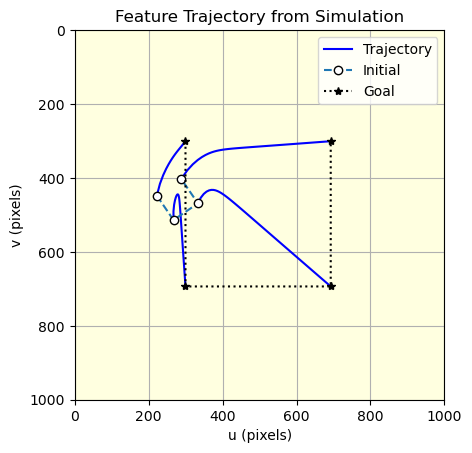

In [43]:
plot_feature_trajectory(uv, c_pose, vel)

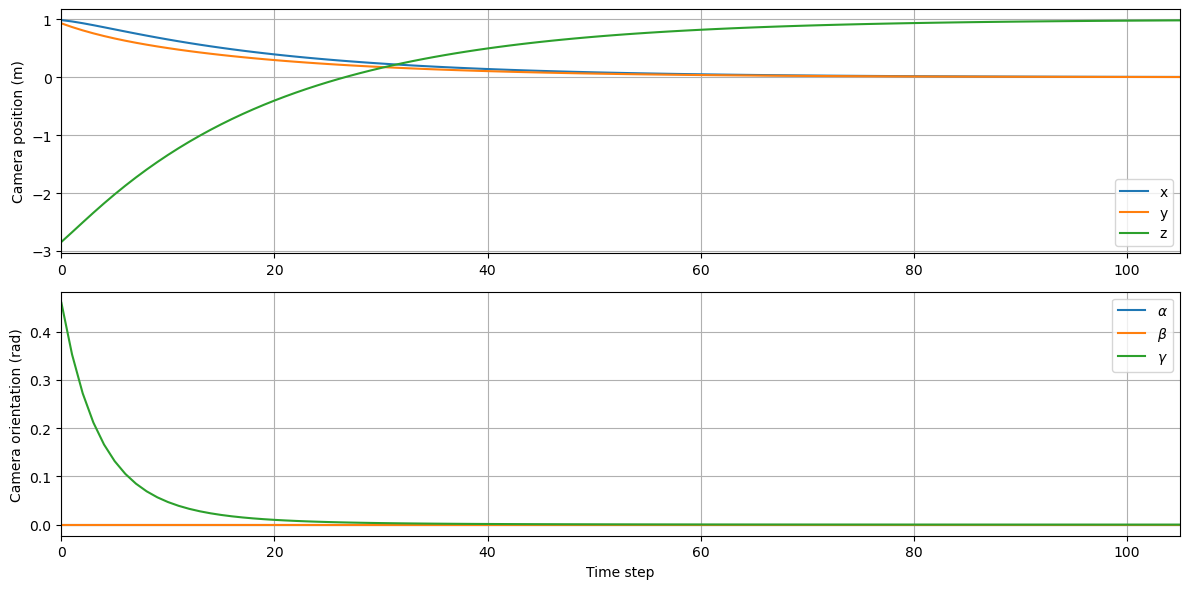

In [44]:
plot_pose(c_pose)

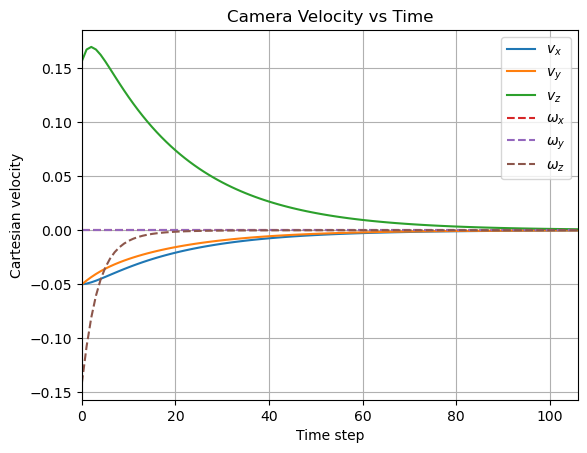

In [45]:
plot_vel(vel)